In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import spearmanr
import statsmodels.api as sm

In [2]:
snp500_ticker = yf.Ticker("^GSPC")
snp_price = snp500_ticker.history(start='1998-10-12', end='2023-09-30', auto_adjust=True)

In [3]:
snp_price['Close']

Date
1998-10-12 00:00:00-04:00     997.710022
1998-10-13 00:00:00-04:00     994.799988
1998-10-14 00:00:00-04:00    1005.530029
1998-10-15 00:00:00-04:00    1047.489990
1998-10-16 00:00:00-04:00    1056.420044
                                ...     
2023-09-25 00:00:00-04:00    4337.439941
2023-09-26 00:00:00-04:00    4273.529785
2023-09-27 00:00:00-04:00    4274.509766
2023-09-28 00:00:00-04:00    4299.700195
2023-09-29 00:00:00-04:00    4288.049805
Name: Close, Length: 6283, dtype: float64

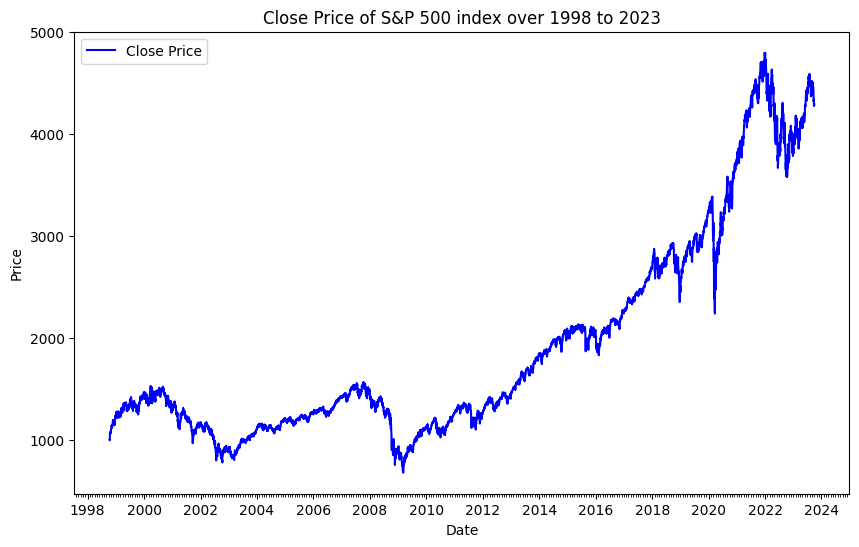

In [4]:
snp_price.index = pd.to_datetime(snp_price.index)
plt.figure(figsize=(10, 6))
plt.plot(snp_price['Close'].index, snp_price['Close'], label='Close Price', color='blue')

# Adding title and labels
plt.title('Close Price of S&P 500 index over 1998 to 2023')
plt.xlabel('Date')  # Assuming your index is date or replace it with an appropriate x-axis label
plt.ylabel('Price')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 

# plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.show()


### Problem 3 (a)

Perform the nonparametric test of independence of the log returns on
S&P500 based on the Spearman rank correlation. What is your conclusion
about whether the EMH holds? Which form of the EMH have you tested
and under which RW assumption?


In [5]:
df = pd.DataFrame()
df['Close'] = snp_price['Close']
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

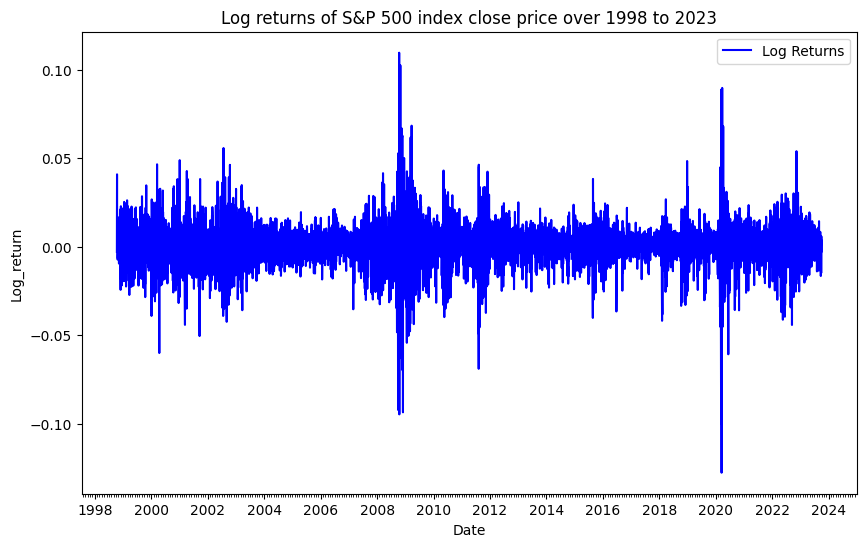

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['log_returns'].index, df['log_returns'], label='Log Returns', color='blue')

# Adding title and labels
plt.title('Log returns of S&P 500 index close price over 1998 to 2023')
plt.xlabel('Date')  # Assuming your index is date or replace it with an appropriate x-axis label
plt.ylabel('Log_return')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 

# plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [7]:
df

,Close,log_returns
Date,,
1998-10-13 00:00:00-04:00,994.799988,-0.002921
1998-10-14 00:00:00-04:00,1005.530029,0.010728
1998-10-15 00:00:00-04:00,1047.489990,0.040882
1998-10-16 00:00:00-04:00,1056.420044,0.008489
1998-10-19 00:00:00-04:00,1062.390015,0.005635
...,...,...
2023-09-25 00:00:00-04:00,4337.439941,0.004015
2023-09-26 00:00:00-04:00,4273.529785,-0.014844
2023-09-27 00:00:00-04:00,4274.509766,0.000229


In [8]:
n = len(df['log_returns'])
group_1 = []
group_2 = []

for x in range(n):
    if x % 2 != 0:
        group_1.append(df.iloc[x, 1])
        
    else:
        group_2.append(df.iloc[x, 1])

group_1.sort()
group_2.sort()

differentials = [x - y for (x, y) in zip(group_1, group_2)]
R = sum(differentials)

z_stat = (6*R - n*((n**2) - 1)) / (n * (n + 1) * np.sqrt(n - 1))
z_stat

corr, p_value = spearmanr(group_1, group_2)

print(f'Hand made z-stat: {z_stat}; scipy func p-val: {p_value}')
    

Hand made z-stat: -79.25276020561701; scipy func p-val: 0.0


As we can see we have strong evidence to reject the null about the absence of dependence in log returns. However this test leverages RW1 e_i ~ iid which is very restrictive and unrealistic assumption that is not holds in returns time series as returns exhibits heteroscedasticity.

Here we attempting to test weak form of EMH as we assess the dependence only with past prices themselves. If the conditions for test would hold then we would conclude that EMH does not hold, but as we use unrealistic assumption our results inconclusive.

### Problem 3 (b)

Estimate the regression of S&P 500 log returns on a constant, the previous
day return, the returns three and nine days ago

In [9]:
df['Lag_1'] = df['log_returns'].shift(1)  
df['Lag_3'] = df['log_returns'].shift(3)  
df['Lag_9'] = df['log_returns'].shift(9)  
df = df.dropna()

(i) Are the coefficients significant (rely on standard asymptotic approximation to answer this question)? What is your conclusion
about whether the EMH holds? Which form of the EMH have you
tested this way and under which RW assumption?

In [10]:
X = sm.add_constant(df[['Lag_1', 'Lag_3', 'Lag_9']])
y = df['log_returns']

model = sm.OLS(y, X)
#results = model.fit(cov_type='HAC', cov_kwds={'maxlags': int(0.75 * (n**(1/3)))})
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     23.54
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           3.82e-15
Time:                        20:14:57   Log-Likelihood:                 18690.
No. Observations:                6273   AIC:                        -3.737e+04
Df Residuals:                    6269   BIC:                        -3.734e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.498      0.1

Under standart asymptotic approximation we can see that Lag_1 and Lag_9 drings significant coefficients as well as confidence interval bounds does not alter their signs. If standart asymtotic approximation would be correct that would mean that weak form of EMH does not hold. We test it under assumption of e ~ iid Normal => RW_1

(ii)  Run a simple (residuals) bootstrap procedure for B = 2000 bootstrap samples. Report two bootstrapped confidence intervals (CI)
for all autoregressive coefficients: percentile bootstrap confidence
intervals and percentile-t bootstrap confidence intervals. Are the
coefficients significant?


In [11]:
original_residuals = results.resid
original_params = results.params

In [12]:
B = 2000  
bootstrap_coefs = np.zeros((B, X.shape[1])) 

for i in range(B):
    #resample the residuals with replacement
    boot_residuals = np.random.choice(original_residuals, size=len(original_residuals), replace=True)
    
    #create a new dependent variable by adding the resampled residuals to the original fitted values
    y_boot = results.fittedvalues + boot_residuals
    
    boot_model = sm.OLS(y_boot, X).fit()
    
    bootstrap_coefs[i, :] = boot_model.params
    

In [13]:
percentile_ci = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)

for i, param_name in enumerate(results.params.index):
    print(f"Percentile CI for {param_name}: [{percentile_ci[0, i]:.4f}, {percentile_ci[1, i]:.4f}]")

Percentile CI for const: [-0.0001, 0.0005]
Percentile CI for Lag_1: [-0.1209, -0.0740]
Percentile CI for Lag_3: [-0.0180, 0.0303]
Percentile CI for Lag_9: [0.0126, 0.0614]


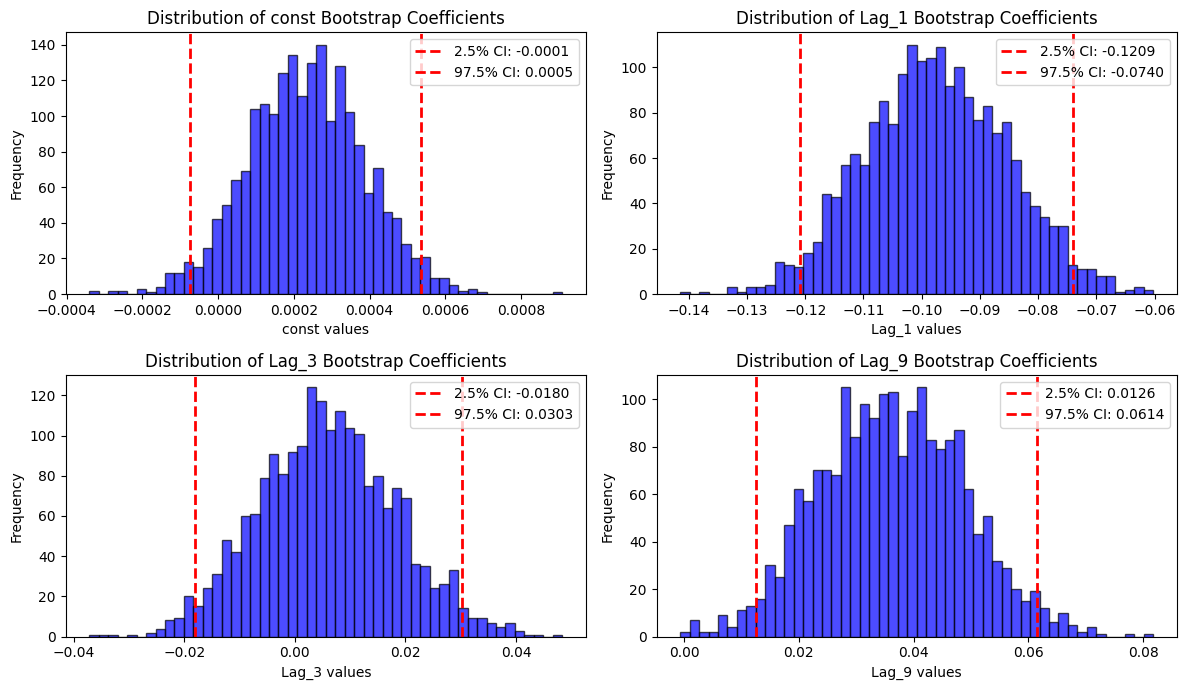

In [24]:
param_names = results.params.index
num_params = len(param_names)

fig, axes = plt.subplots(nrows=(num_params + 1) // 2, ncols=2, figsize=(12, (num_params // 2 + 1) * 4 - 5))

axes = axes.flatten()

for i, param_name in enumerate(param_names):
    axes[i].hist(bootstrap_coefs[:, i], bins=50, alpha=0.7, color='blue', edgecolor='black')

    axes[i].axvline(percentile_ci[0, i], color='red', linestyle='dashed', linewidth=2, label=f'2.5% CI: {percentile_ci[0, i]:.4f}')
    axes[i].axvline(percentile_ci[1, i], color='red', linestyle='dashed', linewidth=2, label=f'97.5% CI: {percentile_ci[1, i]:.4f}')
   
    axes[i].set_title(f'Distribution of {param_name} Bootstrap Coefficients')
    axes[i].set_xlabel(f'{param_name} values')
    axes[i].set_ylabel('Frequency')
    
    
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [36]:
bootstrap_se = np.std(bootstrap_coefs, axis=0)

t_statistics = (bootstrap_coefs - results.params.values) / bootstrap_se

t_percentiles = np.percentile(t_statistics, [2.5, 97.5], axis=0)

percentile_t_ci_lower = results.params.values - t_percentiles[1] * bootstrap_se
percentile_t_ci_upper = results.params.values - t_percentiles[0] * bootstrap_se

for i, param_name in enumerate(results.params.index):
    print(f"Percentile-t CI for {param_name}: [{percentile_t_ci_lower[i]:.4f}, {percentile_t_ci_upper[i]:.4f}]    Percentile CI for {param_name}: [{percentile_ci[0, i]:.4f}, {percentile_ci[1, i]:.4f}]")


Percentile-t CI for const: [-0.0001, 0.0005]    Percentile CI for const: [-0.0001, 0.0005]
Percentile-t CI for Lag_1: [-0.1217, -0.0747]    Percentile CI for Lag_1: [-0.1209, -0.0740]
Percentile-t CI for Lag_3: [-0.0187, 0.0297]    Percentile CI for Lag_3: [-0.0180, 0.0303]
Percentile-t CI for Lag_9: [0.0118, 0.0607]    Percentile CI for Lag_9: [0.0126, 0.0614]


Both percentile and t-percentile bootstraps gives very similar CIs (which confirms t-distribution approxinmation is appropriate). We can see that Lag_1 and Lag_9 seems to be significant as CI for them does not include 0. 

(iii) Run a bootstrap procedure with drawing blocks of length 18 for
 B =2000 bootstrap samples. Report two bootstrapped condence
 intervals (CI) for all autoregressive coe cients: percentile boot
strap condence intervals and percentile-t bootstrap condence in
tervals. Are the coe cients signi cant?

In [80]:
def block_bootstrap_ci(block_size, B=2000, overlap=False, plot=False):

    X = sm.add_constant(df[['Lag_1', 'Lag_3', 'Lag_9']])
    y = df['log_returns']

    model = sm.OLS(y, X).fit()

    original_coefs = model.params
    bootstrap_coefs = np.zeros((B, X.shape[1]))
    n = len(y)
    
    # Function to create block indices for non-overlapping or overlapping blocks
    def create_blocks(overlap):
        if overlap:
            block_starts = np.arange(n - block_size + 1)
        else:
            block_starts = np.arange(0, n, block_size)
        
        return block_starts

    # Function to resample data using block bootstrap
    def block_bootstrap(X, y, block_size, overlap):

        block_starts = create_blocks(overlap)
        sampled_indices = []

        while len(sampled_indices) < n:

            start_idx = np.random.choice(block_starts)
            end_idx = min(start_idx + block_size, n)

            sampled_indices.extend(np.arange(start_idx, end_idx))
        
        if len(sampled_indices) > n + block_size:
            print(f'Length of bootstrap sample are more than {len(block_size)} more than initial sample lenght! Current len: {len(sampled_indices)}')
        elif len(sampled_indices) < n - block_size:
            print(f'Length of bootstrap sample are more than {len(block_size)} less than initial sample lenght! Current len: {len(sampled_indices)}')
        
        sampled_indices = np.array(sampled_indices[:n])  # Ensure exact length
        return X[sampled_indices], y[sampled_indices]
    
    # Bootstrap procedure
    for i in range(B):
        X_boot, y_boot = block_bootstrap(X.values, y.values, block_size, overlap)
        
        boot_model = sm.OLS(y_boot, X_boot).fit()
        
        bootstrap_coefs[i, :] = boot_model.params

    percentile_ci = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)


    bootstrap_se = np.std(bootstrap_coefs, axis=0)
    t_statistics = (bootstrap_coefs - original_coefs.values) / bootstrap_se
    t_percentiles = np.percentile(t_statistics, [2.5, 97.5], axis=0)

    percentile_t_ci_lower = original_coefs.values - t_percentiles[1] * bootstrap_se
    percentile_t_ci_upper = original_coefs.values - t_percentiles[0] * bootstrap_se

    percentile_ci_dict = {param_name: (percentile_ci[0, i], percentile_ci[1, i])
                          for i, param_name in enumerate(model.params.index)}
    percentile_t_ci_dict = {param_name: (percentile_t_ci_lower[i], percentile_t_ci_upper[i])
                            for i, param_name in enumerate(model.params.index)}
    
    if plot:
        param_names = model.params.index
        num_params = len(param_names)

        fig, axes = plt.subplots(nrows=(num_params + 1) // 2, ncols=2, figsize=(12, (num_params // 2 + 1) * 4 - 5))
        axes = axes.flatten()

        # Loop through each parameter and plot its bootstrap distribution and CIs
        for i, param_name in enumerate(param_names):
            axes[i].hist(bootstrap_coefs[:, i], bins=50, alpha=0.7, color='blue', edgecolor='black')

            axes[i].axvline(0, color='black', linestyle='-', linewidth=4)

            # Add percentile confidence intervals
            axes[i].axvline(percentile_ci[0, i], color='red', linestyle='dashed', linewidth=2, label=f'2.5% CI: {percentile_ci[0, i]:.4f}')
            axes[i].axvline(percentile_ci[1, i], color='red', linestyle='dashed', linewidth=2, label=f'97.5% CI: {percentile_ci[1, i]:.4f}')

            # Add percentile-t confidence intervals
            axes[i].axvline(percentile_t_ci_lower[i], color='green', linestyle='dashed', linewidth=2, label=f'Perc-t CI: {percentile_t_ci_lower[i]:.4f}')
            axes[i].axvline(percentile_t_ci_upper[i], color='green', linestyle='dashed', linewidth=2, label=f'Perc-t CI: {percentile_t_ci_upper[i]:.4f}')
            
            axes[i].set_title(f'Distribution of {param_name} Bootstrap Coefficients')
            axes[i].set_xlabel(f'{param_name} values')
            axes[i].set_ylabel('Frequency')
            
            axes[i].legend()

        
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

        for param_name in percentile_ci_dict:
            print(f"Percentile CI for {param_name}: [{percentile_ci_dict[param_name][0]:.4f}, {percentile_ci_dict[param_name][1]:.4f}]    Percentile-t CI for {param_name}: [{percentile_t_ci_dict[param_name][0]:.4f}, {percentile_t_ci_dict[param_name][1]:.4f}]")

    return percentile_ci_dict, percentile_t_ci_dict


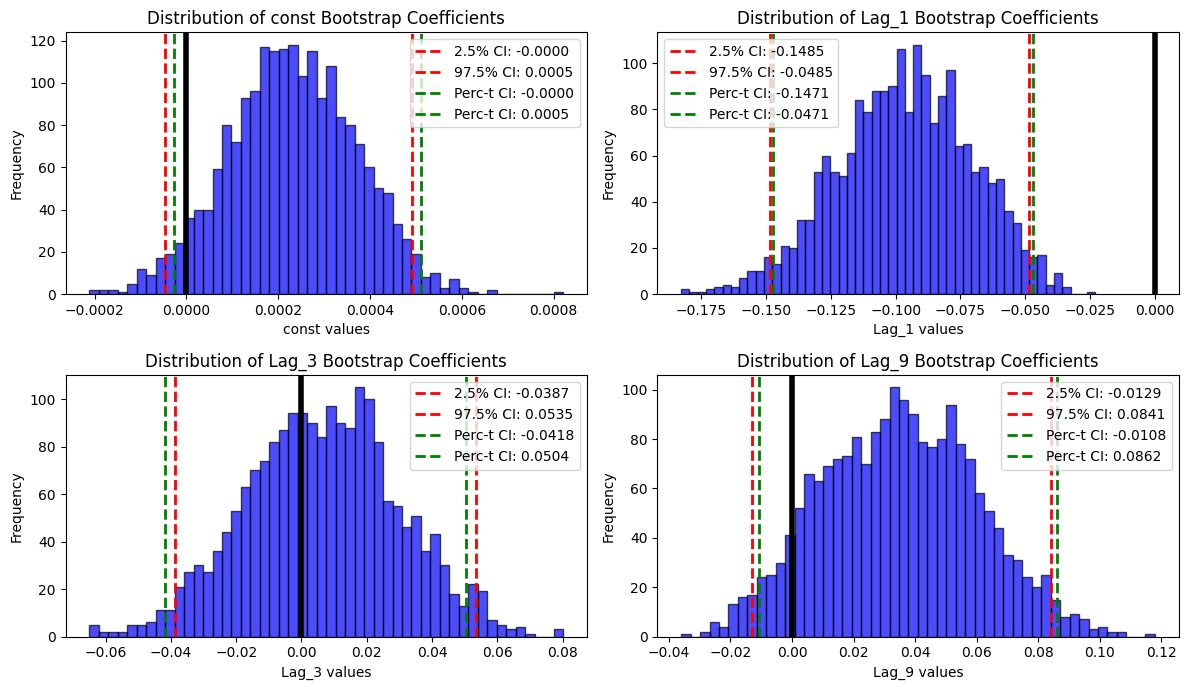

Percentile CI for const: [-0.0000, 0.0005]    Percentile-t CI for const: [-0.0000, 0.0005]
Percentile CI for Lag_1: [-0.1485, -0.0485]    Percentile-t CI for Lag_1: [-0.1471, -0.0471]
Percentile CI for Lag_3: [-0.0387, 0.0535]    Percentile-t CI for Lag_3: [-0.0418, 0.0504]
Percentile CI for Lag_9: [-0.0129, 0.0841]    Percentile-t CI for Lag_9: [-0.0108, 0.0862]


({'const': (-4.549299234452694e-05, 0.0004920115342342557),
  'Lag_1': (-0.1484857598129305, -0.048482108753043346),
  'Lag_3': (-0.03869289802789388, 0.0534563540715866),
  'Lag_9': (-0.012909999527018639, 0.08406462736257374)},
 {'const': (-2.6551029957280157e-05, 0.0005109534966215025),
  'Lag_1': (-0.1471403413471456, -0.04713669028725846),
  'Lag_3': (-0.04179102710333614, 0.050358224996144334),
  'Lag_9': (-0.010812023784555765, 0.08616260310503661)})

In [81]:
block_bootstrap_ci(20, overlap=False, plot=True)

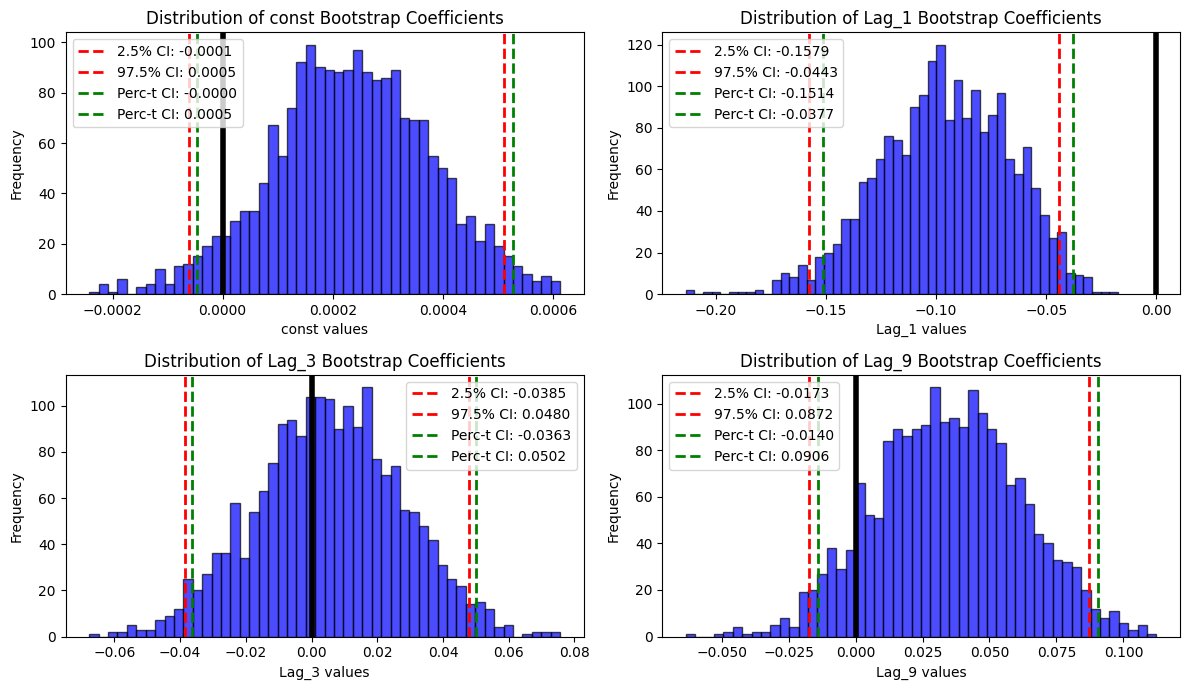

Percentile CI for const: [-0.0001, 0.0005]    Percentile-t CI for const: [-0.0000, 0.0005]
Percentile CI for Lag_1: [-0.1579, -0.0443]    Percentile-t CI for Lag_1: [-0.1514, -0.0377]
Percentile CI for Lag_3: [-0.0385, 0.0480]    Percentile-t CI for Lag_3: [-0.0363, 0.0502]
Percentile CI for Lag_9: [-0.0173, 0.0872]    Percentile-t CI for Lag_9: [-0.0140, 0.0906]


({'const': (-6.1400183764682e-05, 0.0005111563005685254),
  'Lag_1': (-0.15793473380592152, -0.04425127766390675),
  'Lag_3': (-0.03852380281936681, 0.04797286084209201),
  'Lag_9': (-0.01734496651507096, 0.08721399598858588)},
 {'const': (-4.569579629154998e-05, 0.0005268606880416575),
  'Lag_1': (-0.1513711724362822, -0.037687716294267426),
  'Lag_3': (-0.03630753387384156, 0.05018912978761727),
  'Lag_9': (-0.013961392410567916, 0.09059757009308893)})

In [82]:
block_bootstrap_ci(20, overlap=True, plot=True)

Now in both cases with overlapping and non-overlapping blocks we resived only one significant coefficient - first lag (Lag_1) as only this CI does not include zero.